In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
%matplotlib inline
import os
import re

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Sarcasm_Headlines_Dataset_v2.json to Sarcasm_Headlines_Dataset_v2.json


In [ ]:
df = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [ ]:
df = df[['headline','is_sarcastic']]
df.head()

,headline,is_sarcastic
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep. totally nails why congress is falling...,0
2,eat your veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar from getting t...,1
4,mother comes pretty close to using word 'strea...,1


In [ ]:
df['is_sarcastic'].value_counts()

0    14985
1    13634
Name: is_sarcastic, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Sarcasm vs Non-sarcasm')

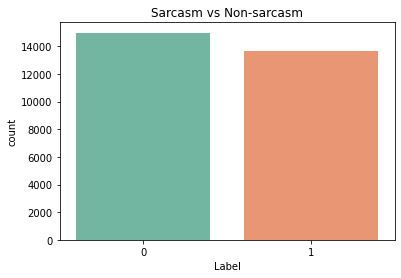

In [ ]:
#using seaborn
sns.countplot(df.is_sarcastic, palette = "Set2" )
plt.xlabel('Label')
plt.title('Sarcasm vs Non-sarcasm')

In [ ]:
df['headline'] = df['headline'].apply(lambda x: x.lower())
df['headline'] = df['headline'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [ ]:
for idx,row in df.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df['headline'].values)
X = tokenizer.texts_to_sequences(df['headline'].values)
X = pad_sequences(X)

In [ ]:
Y = pd.get_dummies(df['is_sarcastic']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(19174, 76) (19174, 2)
(9445, 76) (9445, 2)


In [ ]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

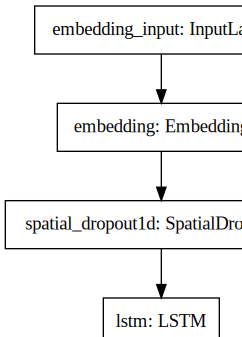

In [ ]:
import keras 
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

keras.utils.vis_utils.pydot = pyd

#Visualize Model

def visualize_model(model):
    return SVG(model_to_dot(model).create(prog='dot', format='svg'))
#create your model
#then call the function on your model
visualize_model(model)

In [ ]:
batch_size = 32
history = model.fit(X_train, Y_train, epochs = 25, batch_size=batch_size, verbose = 2)

Epoch 1/25
600/600 - 237s - loss: 0.4405 - accuracy: 0.7906
Epoch 2/25
600/600 - 229s - loss: 0.3330 - accuracy: 0.8577
Epoch 3/25
600/600 - 229s - loss: 0.2983 - accuracy: 0.8743
Epoch 4/25
600/600 - 229s - loss: 0.2735 - accuracy: 0.8847
Epoch 5/25
600/600 - 229s - loss: 0.2570 - accuracy: 0.8932
Epoch 6/25
600/600 - 229s - loss: 0.2371 - accuracy: 0.8997
Epoch 7/25
600/600 - 229s - loss: 0.2237 - accuracy: 0.9073
Epoch 8/25


KeyboardInterrupt: ignored

In [ ]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("accuracy: %.2f" % (acc))

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

In [ ]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
  result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
  if np.argmax(result) == np.argmax(Y_validate[x]):
    if np.argmax(Y_validate[x]) == 0:
      neg_correct += 1
    else:
      pos_correct += 1
       
  if np.argmax(Y_validate[x]) == 0:
    neg_cnt += 1
  else:
    pos_cnt += 1

print("Sarcasm_acc", pos_correct/pos_cnt*100, "%")
print("Non-Sarcasm_acc", neg_correct/neg_cnt*100, "%")

In [ ]:
#Headline= ['Miracle cure kills fifth patient']
#Headline=['Safety meeting ends in accident']
Headline=['Alton attorney accidentally sues himself']
#Headline=['Sun rises in the East.']
#Headline=['Man Accused of Killing Lawyer Receives a New Attorney']
#Headline=['Federal Agents Raid Gun Shop, Find Weapons']
headline=Headline
headline = tokenizer.texts_to_sequences(headline)
headline = pad_sequences(headline, maxlen=76, dtype='int32', value=0)

sentiment = model.predict(headline,batch_size=1,verbose = 2)[0]

if(np.argmax(sentiment) == 0):
    print("Sentence: %s is Non-sarcastic" %Headline)
elif (np.argmax(sentiment) == 1):
    print("Sentence: %s is Sarcastic" %Headline)